In [1]:
from datasets import load_dataset

dataset = load_dataset('Kili/plastic_in_river', num_proc=6)

print(dataset)

/Users/kevin/miniconda3/envs/cos429/lib/python3.8/site-packages/datasets/load.py:1486: FutureWarning: The repository for Kili/plastic_in_river contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Kili/plastic_in_river
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'litter'],
        num_rows: 3407
    })
    test: Dataset({
        features: ['image', 'litter'],
        num_rows: 427
    })
    validation: Dataset({
        features: ['image', 'litter'],
        num_rows: 425
    })
})


In [ ]:
import os
from tqdm.notebook import tqdm  # Import tqdm from tqdm.notebook module

# only creating datasets for train and validation not test
os.makedirs('datasets/images/train', exist_ok=True)
os.makedirs('datasets/images/validation', exist_ok=True)

os.makedirs('datasets/labels/train', exist_ok=True)
os.makedirs('datasets/labels/validation', exist_ok=True)


def create_dataset(data, split):
  data = data[split]

  print(f'Running for {split} split...')

  for idx, sample in enumerate(data):
    image = sample['image']
    labels = sample['litter']['label']
    bboxes = sample['litter']['bbox']
    targets = []
    
    # creating the label txt files
    for label, bbox in zip(labels, bboxes):
      targets.append(f'{label} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}')
      
    with open(f'datasets/labels/{split}/{idx}.txt', 'w') as f:
      for target in targets:
        f.write(target + '\n')
        
    # saving image to png
    image.save(f'datasets/images/{split}/{idx}.png')

# create_dataset(dataset, 'train')
# create_dataset(dataset, 'validation')

Running for train split...
Running for validation split...


In [2]:
# !pip3 install --upgrade ultralytics
# !pip3 install opencv-python==4.8.0.74
# %conda install ipykernel --update-deps --force-reinstall

  Using cached opencv_python-4.9.0.80-cp37-abi3-macosx_10_16_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.9.0.80-cp37-abi3-macosx_10_16_x86_64.whl (55.7 MB)
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.5.64
    Uninstalling opencv-python-4.5.5.64:
      Successfully uninstalled opencv-python-4.5.5.64
  Using cached opencv_python-4.8.0.74-cp37-abi3-macosx_10_16_x86_64.whl.metadata (19 kB)
Using cached opencv_python-4.8.0.74-cp37-abi3-macosx_10_16_x86_64.whl (54.6 MB)
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.9.0.80
    Uninstalling opencv-python-4.9.0.80:
      Successfully uninstalled opencv-python-4.9.0.80


In [1]:
from ultralytics import YOLO # using YOLO!
import modal

app = modal.App()

model = YOLO('yolov8m.pt') # yolov8 architecture

@app.function(gpu="A100")
def run_obj_detection():
    model.train(
        data = 'plastic.yaml', # this plastic.yaml is the the config file for the object detection 
        epochs = 1, # relatively low for now just for testing
        imgsz = (1280, 720), # width, height
        batch = 4,
        optimizer = 'Adam',
        lr0 = 1e-3,
        device='cpu'
    )
    
run_obj_detection()

Ultralytics YOLOv8.2.3 🚀 Python-3.8.18 torch-2.2.2 CPU (Apple M2)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=plastic.yaml, epochs=1, time=None, patience=100, batch=4, imgsz=(1280, 720), save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train25, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None,

Fontconfig warning: ignoring UTF-8: not a valid region tag
[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Model summary: 295 layers, 25858636 parameters, 25858620 gradients, 79.1 GFLOPs

Transferred 469/475 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
WARNING ⚠️ updating to 'imgsz=1280'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /Users/kevin/Desktop/cv/final_project/obj_detection/datasets/labels/train.cache... 3407 images, 238 backgrounds, 0 corrupt: 100%|██████████| 3407/3407 [00:00<?, ?it/s]
val: Scanning /Users/kevin/Desktop/cv/final_project/obj_detection/datasets/labels/validation.cache... 425 images, 42 backgrounds, 0 corrupt: 100%|██████████| 425/425 [00:00<?, ?it/s]


Plotting labels to /Users/kevin/runs/detect/train25/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 0 dataloader workers
Logging results to /Users/kevin/runs/detect/train25
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      1.623      2.099      1.136          4       1280: 100%|██████████| 852/852 [42:17:39<00:00, 178.71s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [38:13<00:00, 42.47s/it] 


                   all        425       1460      0.572      0.275      0.249     0.0971

1 epochs completed in 42.932 hours.
Optimizer stripped from /Users/kevin/runs/detect/train25/weights/last.pt, 52.1MB
Optimizer stripped from /Users/kevin/runs/detect/train25/weights/best.pt, 52.1MB

Validating /Users/kevin/runs/detect/train25/weights/best.pt...
Ultralytics YOLOv8.2.3 🚀 Python-3.8.18 torch-2.2.2 CPU (Apple M2)
Model summary (fused): 218 layers, 25842076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [52:54<00:00, 58.79s/it]   


                   all        425       1460      0.572      0.275      0.249     0.0971
           PLASTIC_BAG        425        167          1          0     0.0766      0.035
        PLASTIC_BOTTLE        425        785      0.661      0.611      0.624      0.252
   OTHER_PLASTIC_WASTE        425        296      0.284      0.405      0.206     0.0596
     NOT_PLASTIC_WASTE        425        212      0.345     0.0849     0.0884     0.0422
Speed: 1.2ms preprocess, 7463.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /Users/kevin/runs/detect/train25


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fe10c88ea60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0


0: 736x1280 2 PLASTIC_BOTTLEs, 4449.9ms
Speed: 7.0ms preprocess, 4449.9ms inference, 519.2ms postprocess per image at shape (1, 3, 736, 1280)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1., 1.])
conf: tensor([0.4617, 0.4185])
data: tensor([[4.5872e+02, 4.3741e+02, 4.7584e+02, 4.4524e+02, 4.6170e-01, 1.0000e+00],
        [2.4333e+02, 4.3707e+02, 2.5760e+02, 4.4485e+02, 4.1852e-01, 1.0000e+00]])
id: None
is_track: False
orig_shape: (720, 1280)
shape: torch.Size([2, 6])
xywh: tensor([[467.2786, 441.3219,  17.1145,   7.8320],
        [250.4664, 440.9588,  14.2704,   7.7728]])
xywhn: tensor([[0.3651, 0.6129, 0.0134, 0.0109],
        [0.1957, 0.6124, 0.0111, 0.0108]])
xyxy: tensor([[458.7213, 437.4059, 475.8358, 445.2379],
        [243.3312, 437.0724, 257.6016, 444.8452]])
xyxyn: tensor([[0.3584, 0.6075, 0.3717, 0.6184],
        [0.1901, 0.6070, 0.2013, 0.6178]])


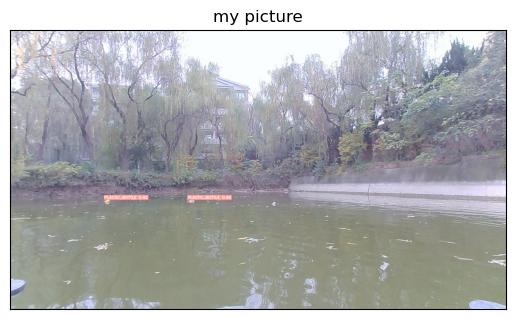

In [3]:
from PIL import Image
from matplotlib import pyplot as plt
from ultralytics import YOLO

img = dataset['test'][0]['image']

# choosing the best training checkpoint
model = YOLO('/Users/kevin/runs/detect/train25/weights/best.pt')

pred = model.predict(img)[0]
print(pred.boxes)

#plotting the image with bounding boxes
pred = pred.plot(line_width=1)
#convert from BGR to RGB
pred_rgb = pred[..., ::-1]
pred_img = Image.fromarray(pred_rgb)

pred_img.save('output.png')
plt.imshow(pred_img)
plt.title('my picture')
plt.xticks([])
plt.yticks([])
plt.show()